# Programmbeispiel: Finite Differenzen (2D)

In diesem Beispiel lösen wir das Problem
$$
- \triangle u(x,y) = f(x,y), \;(x,y) \in \Omega
$$
mit Randwerten $u(x,y) = g(x,y), (x,y)\in \partial \Omega$. 


Damit wir konkret arbeiten können, wählen wir das Einheitsquadrat $\Omega = (0,1)^2$ und betrachten die Lösung 
$$ u(x,y) = \sin (\pi x)\cdot \sin (3\pi y)$$
welche sich für die rechte Seite $f(x,y) = (\pi^2+ (3 \pi)^2) u(x,y)$ und $g(x,y)=0$ ergibt. Zunächst definieren wir die Referenzlösung:

In [1]:
%plot -f svg
solution = @(x,y) (sin(pi.*x) .* sin(3*pi.*y))
f=@(x,y)((pi*pi)+ (3*pi)*(3*pi)) .* solution(x,y)

solution =

@(x, y) (sin (pi .* x) .* sin (3 * pi .* y))

f =

@(x, y) ((pi * pi) + (3 * pi) * (3 * pi)) .* solution (x, y)



Zunächst definieren wir das diskrete Gitter:

In [2]:
# Zaehler
NumCells = 8
NumPoints = NumCells +1
NumDof=NumPoints*NumPoints

# Gitterweite
h = 1.0/NumCells

# Koordinaten
xaxis = linspace(0, 1, NumPoints);
[X,Y] = meshgrid(xaxis,xaxis);

NumCells = 8
NumPoints = 9
NumDof = 81
h = 0.1250


Rechengebiet:

In [3]:
# Rechengebiet
Square=(((X>=0) & (X<=1) & (Y>=0) & (Y<=1)) )
cells = find(Square)
Square = zeros(size(Square));
Square(cells) = (1:length(cells))

Square =

  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1

cells =

    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
   14
   15
   16
   17
   18
   19
   20
   21
   22
   23
   24
   25
   26
   27
   28
   29
   30
   31
   32
   33
   34
   35
   36
   37
   38
   39
   40
   41
   42
   43
   44
   45
   46
   47
   48
   49
   50
   51
   52
   53
   54
   55
   56
   57
   58
   59
   60
   61
   62
   63
   64
   65
   66
   67
   68
   69
   70
   71
   72
   73
   74
   75
   76
   77
   78
   79
   80
   81

Square =

    1   10   19   28   37   46   55   64   73
    2   11   20   29   38   47   56   65   74
    3   12   21   30   39   48   57   66   75
    4   13   22   31   40   49   58   67   76
    5   14   23   32   41   50   59   68   77
 

Innere Punkte

In [4]:
Inner=(((X>0) & (X<1) & (Y>0) & (Y<1)) )
InnerPts = find(Inner)

Inner =

  0  0  0  0  0  0  0  0  0
  0  1  1  1  1  1  1  1  0
  0  1  1  1  1  1  1  1  0
  0  1  1  1  1  1  1  1  0
  0  1  1  1  1  1  1  1  0
  0  1  1  1  1  1  1  1  0
  0  1  1  1  1  1  1  1  0
  0  1  1  1  1  1  1  1  0
  0  0  0  0  0  0  0  0  0

InnerPts =

   11
   12
   13
   14
   15
   16
   17
   20
   21
   22
   23
   24
   25
   26
   29
   30
   31
   32
   33
   34
   35
   38
   39
   40
   41
   42
   43
   44
   47
   48
   49
   50
   51
   52
   53
   56
   57
   58
   59
   60
   61
   62
   65
   66
   67
   68
   69
   70
   71



Randpunkte

In [5]:
Boundary=((X==0) | (X==1) | (Y==0) | (Y==1)) 
BoundaryPts = find(Boundary);

Boundary =

  1  1  1  1  1  1  1  1  1
  1  0  0  0  0  0  0  0  1
  1  0  0  0  0  0  0  0  1
  1  0  0  0  0  0  0  0  1
  1  0  0  0  0  0  0  0  1
  1  0  0  0  0  0  0  0  1
  1  0  0  0  0  0  0  0  1
  1  0  0  0  0  0  0  0  1
  1  1  1  1  1  1  1  1  1



## a) Schritt für Schritt zum LGS
Zunächst initialisieren wir für **innere Knoten** die Matrix und rechte Seite mit
$$
\frac{1}{h^2 }( 4 u_{i,j} -u_{i-1,j} - u_{i+1,j} -u_{i,j-1} - u_{i,j+1}) = f_{i,j}
$$

In [6]:
%writefile create_laplacian.m
function A=create_laplacian(G, n)
    nnz = max(max(G))
    A =zeros(nnz);
    for i=2:n-1
        for j=2:n-1
             ind = G(i,j);
             left = G(i-1,j);
             right = G(i+1,j);
             top = G(i,j+1);
             bot = G(i,j-1);
             
             A(ind,ind) = 4.0;
             if (bot > 0) A(ind,bot) = -1.0; endif
             if (top > 0) A(ind,top) = -1.0; endif
             if (left > 0) A(ind,left) = -1.0; endif
             if (right > 0) A(ind,right) = -1.0; endif
        endfor
    endfor
end

Matrix

In [7]:
A = create_laplacian(Square, NumPoints);
A /= h*h;

nnz = 81


In [8]:
b=zeros(NumDof,1);
b(InnerPts) = f(X(InnerPts), Y(InnerPts));

An den Stellen, an denen **Dirichlet-Randwerte** vorliegen, wird in der Matrix eine Einheitszeile gesetzt und die rechte Seite angepasst:

In [9]:
function [A,b] = set_dirichlet(i, ui, A, b)
    b(i) = ui;
    A(i,:) = 0;
    A(i,i) = eye(length(i));
endfunction

In [10]:
[A,b] = set_dirichlet(BoundaryPts, 0.0, A, b);

Die numerische Lösung kann nun über das aufgestellt **lineare Gleichungssystem** bestimmt werden:

In [11]:
unum = linsolve(A,b);

Die numerische Lösung wollen wir nun darstellen:

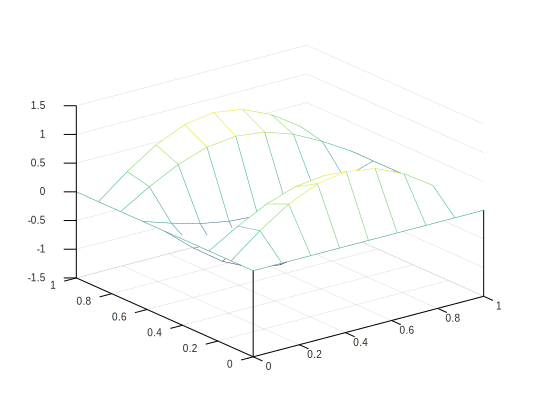

In [12]:
U=Square;
U=full(unum(Square));
mesh(X,Y,U)

Punktweise können wir diese der analytischen Lösung gegenüberstellen. Den Fehler berechnen wir in den Punkten $(x_i, y_j)$:

In [13]:
uref = zeros(NumDof,1);
uref(InnerPts)=solution(X(InnerPts), Y(InnerPts));
err = uref-unum;

herr = 0.1119


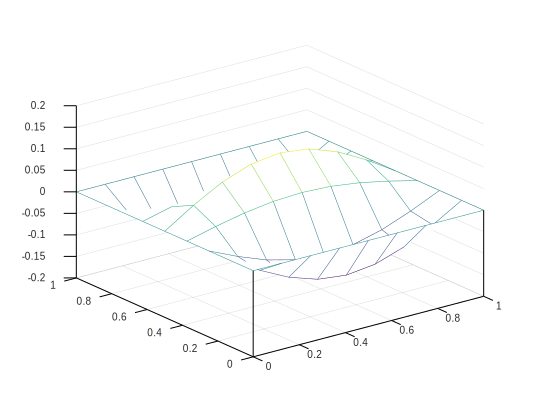

In [14]:
herr=norm(err, inf)
E=full(err(Square));
mesh(X,Y,E)

## b) Studie zur Diskretisierungsgenauigkeit

In [15]:
function [h, herr]=discretization_error(f, NumPoints, solution)

    # Gitterweite
    h = 1.0/(NumPoints-1)
    NumDof=NumPoints*NumPoints;
    
    xaxis = linspace(0, 1, NumPoints);
    [X,Y]=meshgrid(xaxis,xaxis);
    
    
    Square=(((X>=0) & (X<=1) & (Y>=0) & (Y<=1)) );
    cells = find(Square);
    Square = zeros(size(Square));
    Square(cells) = (1:length(cells));

    Inner=(((X>0) & (X<1) & (Y>0) & (Y<1)) );
    InnerPts = find(Inner);

    Boundary=((X==0) | (X==1) | (Y==0) | (Y==1)) ;
    BoundaryPts = find(Boundary);
    
    # Aufstellen des LGS
    A = create_laplacian(Square, NumPoints);
    A /= h*h;
    
    b=zeros(NumDof,1);
    b(InnerPts) = f(X(InnerPts), Y(InnerPts));

    # Loese LGS
    unum = zeros(NumDof,1);
    [A,b] = set_dirichlet(BoundaryPts, 0.0, A, b);
    unum = linsolve(A,b);
    
    # Vergleiche mit Referenzloesung
    uref = zeros(NumDof,1);
    uref(InnerPts)=solution(X(InnerPts), Y(InnerPts));
    err = uref-unum;
    herr=norm(err, inf);
    
endfunction


In [16]:
for k=1:6
    [hGrid(k), hErr(k)] = discretization_error(f, 2**k+1, solution);
endfor 

hGrid(:)
hErr(:)

h = 0.5000
nnz = 9
h = 0.2500
nnz = 25
h = 0.1250
nnz = 81
h = 0.062500
nnz = 289
h = 0.031250
nnz = 1089
h = 0.015625
nnz = 4225
ans =

   0.500000
   0.250000
   0.125000
   0.062500
   0.031250
   0.015625

ans =

   5.1685e+00
   5.4213e-01
   1.1194e-01
   2.6742e-02
   6.6108e-03
   1.6481e-03



error: loglog: properties must appear followed by a value
error: called from
    __plt__ at line 95 column 15
    loglog at line 65 column 10


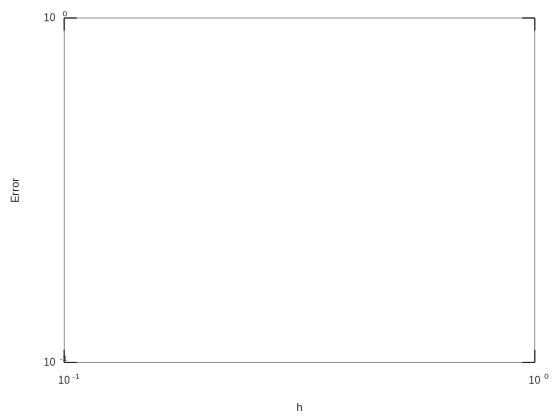

In [18]:
loglog(hGrid,hErr)
xlabel("h")
ylabel("Error")